In [33]:
import pandas as pd

In [34]:
# years we are dealing with
years = [(2021, "SA2_CODE_2021", "SA2", "Statistical Area 2"), (2016, "SA2_MAINCODE_2016", "SA2", "Statistical Area 2")]

# fields we want to extract and the file the data is in : 
# Creating the list of tuples with the shorthand name and G01 or G02 group.
fields_with_names = [
    ("Total_dwelings", "G34","G30"),
    ("Tot_P_P","G01", "G01")
]


fields_with_names

[('Total_dwelings', 'G34', 'G30'), ('Tot_P_P', 'G01', 'G01')]

In [35]:
datasets = []

path = '../../data/landing/'

for i, (year, code, tp, full_nm) in enumerate(years):
    # Create an empty DataFrame for each year to append data into
    yearly_df = pd.DataFrame()
    
    full_path = path + f"{year}_GCP_{tp}_for_VIC_short-header/{year} Census GCP {full_nm} for VIC/"

    for data in fields_with_names:
        # Construct the file path based on year and group
        file = f"{full_path}{year}Census_{data[1 + i]}_VIC_{tp}.csv"
        
        # Read the CSV into a pandas DataFrame
        pandas_df = pd.read_csv(file)
        
        # Filter to only keep the fields of interest (code and the specific field)
        pandas_df = pandas_df[[code, data[0]]]
        
        # If the yearly_df is empty, initialize it with the code column
        if yearly_df.empty:
            yearly_df[code] = pandas_df[code]
        
        # Add the specific field to the yearly DataFrame
        yearly_df[data[0]] = pandas_df[data[0]]

    # Append the complete DataFrame for the year to the datasets list
    datasets.append(yearly_df)


In [36]:
datasets[0].head()

,SA2_CODE_2021,Total_dwelings,Tot_P_P
0,201011001,5763,16835
1,201011002,5036,12131
2,201011005,2522,7261
3,201011006,3870,10661
4,201011007,1395,4230


In [37]:
datasets[1].head()

,SA2_MAINCODE_2016,Total_dwelings,Tot_P_P
0,201011001,3886,11654
1,201011002,4654,12046
2,201011003,8992,23083
3,201011004,9868,24231
4,201011005,2281,7153


In [38]:
datasets[0] = datasets[0].rename(columns={"SA2_CODE_2021": 'SA2_CODE'})
datasets[1] = datasets[1].rename(columns={"SA2_MAINCODE_2016": 'SA2_CODE'})

years = [2021, 2016]

data_per_year = {x: datasets[i] for i,x in enumerate(years)}


In [39]:
# get projections
projections = pd.read_excel('../../data/landing/VIF2023_SA2_Pop_Hhold_Dwelling_Projections_to_2036_Release_2.xlsx', sheet_name='Total_Population', skiprows=9)
projections.head()

dwelling_projections = pd.read_excel('../../data/landing/VIF2023_SA2_Pop_Hhold_Dwelling_Projections_to_2036_Release_2.xlsx', sheet_name='Total_Dwellings', skiprows=9)

projections = projections.drop(0)
dwelling_projections.head()



,GCCSA,SA4 Code,SA3 Code,SA2 code,Region Type,Region,2021,2026,2031,2036
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2RVIC,201.0,20101.0,201011001.0,SA2,Alfredton,6245.0,8252.000000,9732.000000,10830.000000
2,2RVIC,201.0,20101.0,201011002.0,SA2,Ballarat,5970.0,6134.548371,6350.037451,6553.095884
3,2RVIC,201.0,20101.0,201011005.0,SA2,Buninyong,2768.0,2943.325691,3199.637967,3445.433425
4,2RVIC,201.0,20101.0,201011006.0,SA2,Delacombe,4172.0,6585.376102,8740.266903,10770.851234


In [40]:
dwelling_projections.columns


Index([      'GCCSA',    'SA4 Code',    'SA3 Code',   'SA2  code',
       'Region Type',      'Region',          2021,          2026,
                2031,          2036],
      dtype='object')

In [41]:
years = [2026, 2031, 2036]

projections_refined = projections[['SA2  code', *years]]
dwellings_refined = dwelling_projections[['SA2  code', *years]]



In [42]:
# combine on SA2 code


In [43]:

for year in years:
    pop_year = projections_refined[['SA2  code',year]]
    dwellings_year = dwellings_refined[['SA2  code',year]]

    combined_df = pd.merge(pop_year, dwellings_year, on='SA2  code', suffixes=('_pop', '_dwellings'))

    combined_df = combined_df.rename(columns={f"{year}_pop" : "Tot_P_P", f"{year}_dwellings" : 'Total_dwelings', "SA2  code": "SA2_CODE"})
    
    # remove Nan
    combined_df = combined_df.dropna(subset=['SA2_CODE'])

    combined_df["SA2_CODE"] = combined_df["SA2_CODE"].astype(int).astype(str)

    data_per_year[year] = combined_df




data_per_year[2026]



,SA2_CODE,Tot_P_P,Total_dwelings
0,201011001,20756.256163,8252.000000
1,201011002,11698.293593,6134.548371
2,201011005,7372.079773,2943.325691
3,201011006,15915.186041,6585.376102
4,201011007,4312.098530,1600.000000
...,...,...,...
517,217031476,4111.484475,4211.361160
518,217041477,7186.714909,3434.000000
519,217041478,10405.281786,5420.538505
520,217041479,23254.186429,10423.000000


In [44]:
import geopandas as gpd

In [45]:
sa2_shapefile = gpd.read_file('../../data/landing/SA2_2021_map/SA2_2021_AUST_GDA2020.shp')
sal_shapefile = gpd.read_file("../../data/landing/SAL_data/SAL_2021_AUST_GDA2020.shp")

sa2_shapefile = sa2_shapefile[sa2_shapefile['STE_NAME21'] == "Victoria"]
sal_shapefile = sal_shapefile[sal_shapefile['STE_NAME21'] == "Victoria"]

sa2_shapefile.SA2_CODE21 = sa2_shapefile.SA2_CODE21.astype(str)
sal_shapefile.SAL_CODE21 = sal_shapefile.SAL_CODE21.astype(str)

sa2_shapefile = sa2_shapefile.rename(columns={"SA2_CODE21": "SA2_CODE"})
sal_shapefile = sal_shapefile.rename(columns={"SAL_CODE21" : "SAL_CODE"})

sa2_shapefile = sa2_shapefile.to_crs('EPSG:3857')
sal_shapefile = sal_shapefile.to_crs('EPSG:3857')

intersection = gpd.overlay(sa2_shapefile, sal_shapefile, how='intersection')
intersection['area'] = intersection.geometry.area


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_52462/746563805.py:16: UserWarning: `keep_geom_type=True` in overlay resulted in 48 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  intersection = gpd.overlay(sa2_shapefile, sal_shapefile, how='intersection')


In [46]:
for dataset in data_per_year.values():
    dataset["SA2_CODE"] = dataset["SA2_CODE"].astype(str)

In [47]:
SAL_data_per_year = {}

for year, dataset in data_per_year.items():
    # Merge SA2 data with intersection data on 'SA2_code'
    intersection_merged = intersection.merge(dataset, on='SA2_CODE')
    

    # Calculate total area of each SA2 region
    total_sa2_area = intersection.groupby('SA2_CODE')['area'].sum().reset_index()
    total_sa2_area = total_sa2_area.rename(columns={'area': 'total_sa2_area'})

    # Merge the total SA2 area back to the intersection dataframe
    intersection_merged = intersection_merged.merge(total_sa2_area, on='SA2_CODE')

    # Calculate area weight for each intersection
    intersection_merged['area_weight'] = intersection_merged['area'] / intersection_merged['total_sa2_area']

    # Assuming the attribute to be weighted is 'attribute_of_interest'
    intersection_merged['weighted_pop'] = intersection_merged['Tot_P_P'] * intersection_merged['area_weight']
    intersection_merged['weighted_dwellings'] = intersection_merged['Total_dwelings'] * intersection_merged['area_weight']

    # Sum the weighted attribute values by SAL_code to get the final result
    sal_weighted = intersection_merged.dissolve(by='SAL_CODE', aggfunc='sum')[['Tot_P_P', 'Total_dwelings']]

    sal_weighted.reset_index(inplace=True)

    SAL_data_per_year[year] = sal_weighted


/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_52462/2176660702.py:23: FutureWarning: The default value of numeric_only in aggfunc='sum' within pandas.DataFrameGroupBy.agg used in dissolve is deprecated. In pandas 2.0, numeric_only will default to False. Either specify numeric_only as additional argument in dissolve() or select only columns which should be valid for the function.
  sal_weighted = intersection_merged.dissolve(by='SAL_CODE', aggfunc='sum')[['Tot_P_P', 'Total_dwelings']]
/var/folders/vs/mmhmvz2124bdlbwz4b6zdqqh0000gn/T/ipykernel_52462/2176660702.py:23: FutureWarning: The default value of numeric_only in aggfunc='sum' within pandas.DataFrameGroupBy.agg used in dissolve is deprecated. In pandas 2.0, numeric_only will default to False. Either specify numeric_only as additional argument in dissolve() or select only columns which should be valid for the function.
  sal_weighted = intersection_merged.dissolve(by='SAL_CODE', aggfunc='sum')[['Tot_P_P', 'Total_dwelings

In [48]:
SAL_data_per_year[2031]

,SAL_CODE,Tot_P_P,Total_dwelings
0,20001,19493.375844,10837.500000
1,20002,85076.615533,43624.000000
2,20003,77659.692082,36868.000000
3,20004,6786.937291,3451.899342
4,20005,11875.767670,7406.000000
...,...,...,...
2939,22940,6825.182854,3644.689170
2940,22941,83687.310308,28302.000000
2941,22942,11160.263714,8021.519874
2942,22943,26379.073986,11362.695151


In [49]:
import pandas as pd
import numpy as np

# Years to interpolate (from 2016 to 2031)
interp_years = list(range(2016, 2032))

# Step 1: Consolidate Data
# Combine all DataFrames into one
combined_df = pd.DataFrame()
for year, df in SAL_data_per_year.items():
    df = df.copy()
    df['Year'] = year
    combined_df = pd.concat([combined_df, df], ignore_index=True)

In [50]:
combined_df

,SAL_CODE,Tot_P_P,Total_dwelings,Year
0,20001,18828.000000,7043.000000,2021
1,20002,64918.000000,28409.000000,2021
2,20003,64490.000000,25960.000000,2021
3,20004,6585.000000,2409.000000,2021
4,20005,11010.000000,4587.000000,2021
...,...,...,...,...
14684,22940,6916.392425,3791.502442,2036
14685,22941,100327.761810,34002.000000,2036
14686,22942,11205.952945,8305.532938,2036
14687,22943,27563.496184,12008.360020,2036


In [51]:
# Define the years you want to interpolate over
interp_years = np.arange(2016, 2032)  # Adjust the range as needed

# Correct the variable names if necessary
variables = ['Total_dwelings', 'Tot_P_P']  # Ensure these match your DataFrame columns

# Initialize a list to store interpolated data
interpolated_data = []

# Step 3: Perform Interpolation
for sal_code in sal_codes:
    # Filter data for the current SAL_CODE
    sal_data = combined_df[combined_df['SAL_CODE'] == sal_code]
    
    for variable in variables:
        # Extract known years and values for the current variable
        known_years = sal_data['Year'].values
        known_values = sal_data[variable].values
        
        # Check if there are enough data points
        if len(known_years) < 2:
            continue  # Skip if not enough data
        
        # Sort the known years and values
        sorted_indices = np.argsort(known_years)
        known_years = known_years[sorted_indices]
        known_values = known_values[sorted_indices]
        
        # Perform linear interpolation
        interp_values = np.interp(interp_years, known_years, known_values)
        
        # Create a DataFrame for the interpolated data
        interp_df = pd.DataFrame({
            'Year': interp_years,
            'SAL_CODE': sal_code,
            variable: interp_values
        })
        
        # If the variable is the first one, initiate the DataFrame
        if variable == variables[0]:
            sal_interp_df = interp_df
        else:
            # Merge with the existing DataFrame
            sal_interp_df = pd.merge(sal_interp_df, interp_df, on=['Year', 'SAL_CODE'])
    
    # Append the interpolated data for the current SAL_CODE
    interpolated_data.append(sal_interp_df)

# Step 4: Combine All Interpolated Data
# Concatenate all interpolated DataFrames
final_interpolated_df = pd.concat(interpolated_data, ignore_index=True)

# Sort the DataFrame by Year and SAL_CODE for better readability
final_interpolated_df.sort_values(by=['Year', 'SAL_CODE'], inplace=True)

# Reset index
final_interpolated_df.reset_index(drop=True, inplace=True)

# Display the interpolated data
print(final_interpolated_df)


       Year SAL_CODE  Total_dwelings       Tot_P_P
0      2016    20001     6528.000000  17754.000000
1      2016    20002    10700.000000  25741.000000
2      2016    20003    12449.000000  33389.000000
3      2016    20004     2172.000000   6019.000000
4      2016    20005     3968.000000   9897.000000
...     ...      ...             ...           ...
47099  2031    22940     3644.689170   6825.182854
47100  2031    22941    28302.000000  83687.310308
47101  2031    22942     8021.519874  11160.263714
47102  2031    22943    11362.695151  26379.073986
47103  2031    22944     9730.036956  17724.018674

[47104 rows x 4 columns]


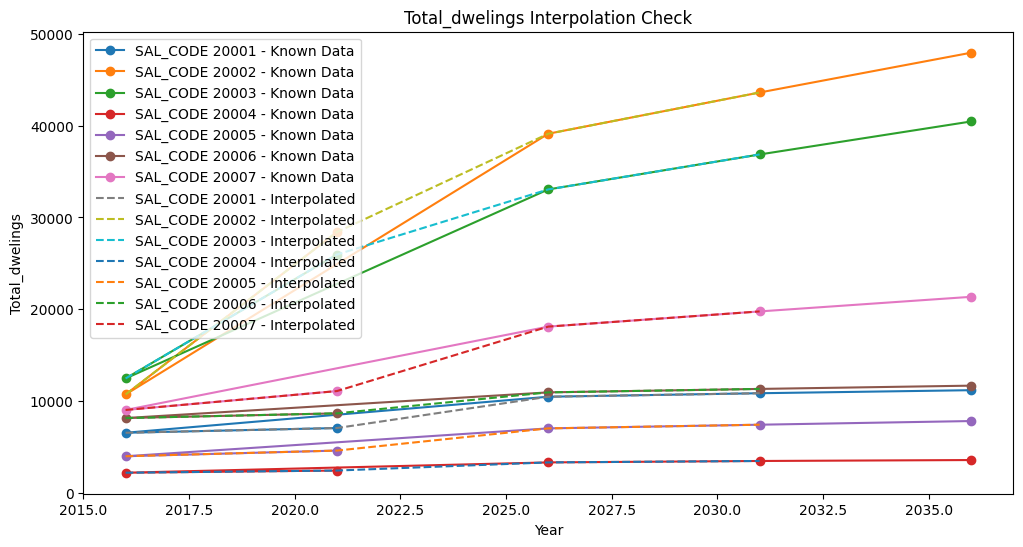

In [52]:
import matplotlib.pyplot as plt

# Plot known data
plt.figure(figsize=(12, 6))
for sal_code in sal_codes[:7]:
    sal_data = combined_df[combined_df['SAL_CODE'] == sal_code]
    plt.plot(sal_data['Year'], sal_data['Total_dwelings'], 'o-', label=f'SAL_CODE {sal_code} - Known Data')
    
# Plot interpolated data
for sal_code in sal_codes[:7]:
    interp_data = final_interpolated_df[final_interpolated_df['SAL_CODE'] == sal_code]
    plt.plot(interp_data['Year'], interp_data['Total_dwelings'], '--', label=f'SAL_CODE {sal_code} - Interpolated')

plt.legend()
plt.title('Total_dwelings Interpolation Check')
plt.xlabel('Year')
plt.ylabel('Total_dwelings')
plt.show()


In [53]:
# group by year

import os

os.makedirs("../../data/curated/pop_projections",exist_ok=True)

for year in range(2016,2031):
    by_year = final_interpolated_df[final_interpolated_df["Year"] == year]

    by_year = by_year.drop(columns=['Year'])

    # save file
    by_year.to_csv(f"../../data/curated/pop_projections/pop_{year}.csv", index=False)